# Cloning Content

## Table of Contents

 * [Introduction](#introduction)
 * [Import libraries](#Import-libraries)
 * [Connect to Web GIS Systems](#Connect-to-source-and-target-portals)
 * [Get Started with Cloning](#Get-started-with-cloning)
 * [Cloning Multiple Items Simultaneously](Cloning-multiple-items-simultaneously)
 * [Helper Functions](#Helper-functions)
 * [The Cloning Process](#the-cloning-process)
   * [Feature Layers](#Feature-Layers)
   * [Web Maps](#Web-Maps)
   * [ArcGIS Dashboards](#ArcGIS-Dashboards)
   * [Story Maps](#Story-Maps)
 * [Conclusion](#Conclusion)

## Introduction

One request the Python API team has heard repeatedly from Web GIS administrators: What's the best way to move my content from a development Enterprise or organization to staging to production?

This Guide provides one possible roadmap for how to get content from one Web GIS to another - a template for demonstrating basic software concepts when transferring content so the workflow can be modified for other types of content and tailored for an administrator's particular need. So, first question to answer is: What does it mean to `clone`? Merriam-Webster defines [`clone`](https://www.merriam-webster.com/dictionary/cloning) as the action of _"propagat[ing] a clone from."_ (Didn't I hear my 2nd grade teacher - and every teacher after that for that matter - say it's unhelpful to use the word you are defining in its definition?...) Diving further into the definition of a _"clone"_, it reads _"the aggregate of genetically identical cells or organisms asexually produced by or from a single progenitor cell or orgasm."_ Okay, not exactly the context we're working in when discussing a Web GIS. Further along the definition we get to something more along the lines of what we're thinking: _"one that appears to be a copy of an original form."_ BINGO! 

Leveraging the Python API to clone content from one Web GIS to another can be thought of as _"propagating content that appears to be a copy of the original content."_. Given all the different content and item types, possible Enterprise configurations, potential ArcGIS Online Organization arrangements, security considerations, and item dependencies the [`clone_items()`]((https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.clone_items)) function aims to _propagate_ an exact duplicate of one item with all its uses and functionality from an original portal to a second portal, but there may be circumstances that lead the clone to come close but not quite produce an identical copy. In addition, the variety of means for publishing items creates varying possibilities for supported, related, or source items created during the publishing process. The relationship between any supported, related, or source items must be considered when cloning an item. For example, the overwrite functionality will not be available on cloned hosted feature layer items, because they do not have a source document from which they were published. The FAQ [here](https://doc.arcgis.com/en/arcgis-online/reference/faq.htm#DELETE_SRC) provides important information regarding source items in ArcGIS Online. However, given our education on `cloning`, we now know that cloning an item produces a second item which appears - but may not be identical to the original. It's important to temper expectations when thinking about the Python API `clone_items()` function. There may be times items will not migrate as expected. 

When talking about cloning items, let's establish some basic terminology.  Cloning can refer to all kinds of transfer, from ArcGIS Enterprise to ArcGIS Online, Enterprise to Enterprise, or ArcGIS Online to Enterprise. (The GIS Community less frequently discusses the need to clone between two distinct ArcGIS Online Organizations, but that is possible as well.) Rather than tangling ourselves up when trying to distinguish between these portal types while writing about them, we'll refer to the portal or organization where the content originates as the _source_ regardless of portal type. We'll consider the portal or organization to which we'll clone content as the _target_. Onward we go!

This document illustrates the workflow of gathering _source_ items using a source administrator account, and cloning them into a _target_ administrator account.  More specifically, this guide walks through an approach of cloning data services known as [`hosted feature layers`](https://doc.arcgis.com/en/arcgis-online/manage-data/hosted-web-layers.htm) that are used as building blocks for other Web GIS items, namely [`web maps`](https://developers.arcgis.com/documentation/core-concepts/web-maps/). `Web Maps` consume these data services as operational layer building blocks. We'll then clone an [`ArcGIS Dashboard`](https://doc.arcgis.com/en/dashboards/get-started/what-is-a-dashboard.htm) and a [`Web Mapping Application`](https://doc.arcgis.com/en/arcgis-online/create-maps/create-map-apps.htm) that each consume a `web map` as part of their definition. For information on each of these item types, please click the hyperlinks for each type.

This is an administrator workflow. Using administrator accounts guarantees all necessary privileges within the _source_ to access the item and any dependencies and within the _target_ to create the services and items. The target administrator subsequently can create user accounts and reassign item ownership and/or group membership according to need. This might also be the simplest workflow when the portal has users managed by an external identity store.

> **NOTE:** Cloning relies on the sharing model to determine the items any particular [`user`](https://develoipers.arcgis.com/python/api-reference/arcgis.gis.toc.html#user) can clone. If a user can access an item, that user can clone it. However, that user can't create anything in the target portal they don't have the appropriate [`privileges`](https://enterprise.arcgis.com/en/portal/latest/administer/windows/roles.htm#ESRI_SECTION1_4FF9051EFB814C249AB26B0ACFF7C79F) to create. 

Any content in any portal must be owned by a [`user`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#user), so at least one _user_ must exist in the target. If you don't plan on using the administrator accounts in a workflow such as this, you may want to investigate the [`Clone Portal users, groups and content`](../sample-notebooks/clone-portal-users-groups-and-content/#Copy-Users) sample notebook on how to define functions that can copy `user` objects and then clone content using those accounts. 

As originally written, Python API developers designed the `clone_items()` function for transferring the following item types:
 * Hosted Web Applications built with Web AppBuilder or shared using Configurable App Templates
 * Web Maps
 * Hosted Feature Layers
 * Hosted Feature Layer Views
 * Feature Collections
 * Survey123 Forms
 * Workforce Projects
 * Story Maps (classic)
 * Operation Views
 * Dashboards
 * QuickCapture Projects
 * ArcGIS Notebooks 
 * Simple Types
   * Those items with a download option (see [Data files](https://developers.arcgis.com/rest/users-groups-and-items/items-and-item-types.htm) for items that may be in a Web GIS and available for download), including zipped file geodatabases and shapefiles, code samples, zip files, and packages amongst others.

`clone_items()` clones the dependencies for the more complex items listed above. For example, cloning an existing web application, clones the web map and all hosted feature layers referenced in the map.

`clone_items()` will not clone map services and image services. Since these services can be published to servers other than the hosted server in a configuration, it's impossible for the function to determine where to publish them in the target. As a result, these items will copy over, but will continue to point back to the original source URL. 

Let's work through examples of cloning individual items and inspect the results.


First, let's import the necessary libraries and connect to our source and target GIS:

### Import libraries

In [1]:
from pathlib import Path
import sys

from arcgis.gis import GIS, Item
from arcgis.env import active_gis
from arcgis.features import FeatureLayerCollection
from arcgis.mapping import WebMap

### Connect to source and target portals

Let's start from a discovery position as an administrator. We'll simulate an administrator who's been testing and developing using an on-premise [ArcGIS Enterprise](https://enterprise.arcgis.com/en/get-started/latest/windows/what-is-arcgis-enterprise-.htm) system as a development environment and wants to clone user data into an [ArcGIS Online](https://doc.arcgis.com/en/arcgis-online/get-started/what-is-agol.htm) environment for further development.

In [2]:
source = GIS(profile="your_ent_admin_profile", verify_cert=False)
print(source)

GIS @ https://pythonapi.playground.esri.com/portal version:7.1


In [3]:
#target = GIS(profile="your_online_admin_profile", verify_cert=False)
target = GIS(profile="cloning_admin", verify_cert=False)
print(target)

GIS @ https://geosaurus.maps.arcgis.com version:8.1


### Get started with cloning

Let's start with an immediate demonstration of what `clone_items()` can do. We're logged in as an administrator and we'll `get()` a specific hosted feature layer item owned by one of the users in the _source_. We'll then clone it into the _target_ while utilizing the `owner` parameter to specify a particular `User` in the _target_ to own the cloned content. We can quickly examine the resulting `url` of the cloned feature layer to confirm the new item.

In [12]:
hosted_flyr = source.content.get("07b60a9efa0342efb66704dfc5aff5c9")
hosted_flyr

<Item title:"Hospitals in Arkansas" type:Feature Layer Collection owner:api_cloner>

In [16]:
hosted_flyr.url

'https://pythonapi.playground.esri.com/server/rest/services/Hosted/Hospitals_in_Arkansas/FeatureServer'

In [13]:
cloned_flyr = target.content.clone_items(items=[hosted_flyr],
                                        owner="api_data_owner")

In [15]:
cloned_flyr[0]

<Item title:"Hospitals in Arkansas" type:Feature Layer Collection owner:api_data_owner>

In [17]:
cloned_flyr[0].url

'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Hospitals_in_Arkansas/FeatureServer'

We can see that the `clone_items()` function returns a list containing the cloned items. Indexing the list we can see the operation created a new hosted feature layer in the _target_ organization owned by the `api_data_owner` user we entered as the `owner` argument. 

### Cloning multiple items simultaneously

We demonstrated above passing one item in the `items` parameter list. Now let's see how `clone_items()` will clone every item in the list. First let's [`search()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.search) the _source_ function for items owned by a particular user and clone the list items into our _target_ all at the same time.

In [23]:
tester_content = source.content.search("owner:api_tester")
tester_content

[<Item title:"Earthquakes Above Magnitude 7 Since 1970" type:CSV owner:api_tester>,
 <Item title:"Earthquakes Above Magnitude 7 Since 1970" type:Feature Layer Collection owner:api_tester>,
 <Item title:"Configuring Apps for Mobile Use" type:Microsoft Word owner:api_tester>]

In [18]:
cloned_items = target.content.clone_items(items=tester_content)

In [19]:
cloned_items

[<Item title:"Earthquakes Above Magnitude 7 Since 1970" type:CSV owner:clonerator>,
 <Item title:"Configuring Apps for Mobile Use" type:Microsoft Word owner:clonerator>,
 <Item title:"Earthquakes Above Magnitude 7 Since 1970" type:Feature Layer Collection owner:clonerator>]

We can see that the `clone_items()` function cloned all the items in the list we passed to the `items` argument. Looking at the output above, we can see all the items in our list were cloned. We can also see that by not passing in an `owner` argument, the items are owned by the logged in user that ran `clone_items()`.

In [22]:
target.users.me.username

'clonerator'

There's a quick demonstration of how the `clone_items()` function replicates items from a _source_ to a _target_. Now let's move onto iterating through a list of hosted feature layers and working with some additonal parameters to clone information products that consume them.

### Helper functions
Let's write a set of helper functions we can reuse throughout the notebook.

Since we're working in two different portals during the notebook, we'll create a variable called `active_gis` to refer to either of these Web GIS systems.  We'll use that variable inside our functions, so we can run them inside each portal.

In [4]:
active_gis = source

Next, we'll create a function that takes a `User` object and a `GIS` object as input and returns a dictionary with a unique `item_type` as the key and a list of all the items of that type owned by the user as the value. Since this notebook is geared towards an `administrator` user, the administrator can retrieve the inventory of any user within the portal

In [1]:
def get_user_items(user, active_gis):
    user_inventory = {}
    user_items = active_gis.content.search(query=f"* AND owner:{user.username}", 
                                           max_items=500)
    for item in user_items:
        if item.type not in user_inventory:
            user_inventory[item.type] = [i 
                                         for i in user_items 
                                         if i.type == item.type]
    return user_inventory

Next, we'll define a function to print the output from the `get_user_items()` function we previously created and prints it in a format to give us a quick glimpse at any user's item inventory.

In [6]:
def print_user_inventory(inventory):
    for itype, ilist in inventory.items():
        try:
            print(f"{itype}\n{'-'*50}")
            for i in ilist:
                print(f"{' ':3}{i.title:50}")
            print("\n")
        except Exception as e:
            print(f"\t\tOperation failed on: {i.title}")
            print(f"\t\tException: {sys.exc_info()[1]}")
            continue

Next, we'll create a function that will take a `feature service` item type from the item inventory we create with `get_user_items()` and return any `Web Map` object within the inventory that consumes that feature service. This can help us make sure web maps contain the appropriate layers between _source_ and _target_. 

In [7]:
def get_fs_webmaps(fs, inv):
    fs_webmap_inventory = {}
    fs_inv = []
    try:
        for wm in inv['Web Map']:
            if fs.id in get_layer_item_ids(wm):
                if not wm in fs_inv:
                    fs_inv.append(wm)
        fs_webmap_inventory[fs.title] = fs_inv
        return fs_webmap_inventory
    except KeyError as ke:
        pass

We'll also create a function that inspects a `web map` and returns all the unique [`item id`](https://community.esri.com/community/gis/web-gis/arcgisonline/blog/2019/06/06/where-can-i-find-the-item-id-for-an-arcgis-online-item) (click the hyperlink to read a blog on the importance of the `item id`) values consumed in that web map. When cloning the set of `feature services` from our inventory, we'll create a mapping of _source_ feature service to corresponding _target_ feature service cloned from the _source_.  Then when we subsequently clone a `web map`, we can use the `get_layer_item_ids()` function to compare the item id values serving as layers in the web map to the dictionary of _source_/_target_ feature service ids we already cloned. If there are any matches between the two, we can create a dictionary to use as a parameter for the `clone_items()` function to ensure the function knows which id to match to which when swizzling the ids in the cloned map. We'll demonstrate this later in the notebook.

In [12]:
def get_layer_item_ids(wm):
    wmo = WebMap(wm)
    wm_id_list = []
    for layer in wmo.layers:
        try:
            fsvc = FeatureLayerCollection(layer['url'][:-1], active_gis)
            if not fsvc.properties['serviceItemId'] in wm_id_list:
                wm_id_list.append(fsvc.properties['serviceItemId'])
        except Exception as e:
            pass
    return wm_id_list

We'll create a function to return a list of any `web map` items consumed in a `dashboard`. If we know the item id of the web map, and we've alreay cloned it, we can then map the _source_ web map to the _target_ web map in a parameter of the `clone_items()` function to ensure correct swizzling of values.

In [13]:
def get_dash_wm(dash):
    return [active_gis.content.get(widget['itemId']) 
            for widget in dash.get_data()['widgets'] 
            if widget['type'] == "mapWidget"]

Ok, so we've created some helper functions. Now let's inventory the items owned by the source administrator and then print out the inventory to get an idea of what items the administrator owns.

In [14]:
source_admin_inventory = get_user_items(source.users.me, source)

In [15]:
print_user_inventory(source_admin_inventory)

Map Service
--------------------------------------------------
   Jordan                                            
   Toronto Greenspace and Community Housing          


Dashboard
--------------------------------------------------
   New Orleans Service Calls                         


Web Map
--------------------------------------------------
   Elephant Corridors and Ranges                     
   Kenya Administrative Boundaries                   
   New Orleans Service Calls per Police District 2011-2019


Feature Service
--------------------------------------------------
   KEN Waterways                                     
   Airport_locations                                 
   Nairobi County Boundaries                         
   NOLA_Police_District_Subzone_Boundaries           
   Botswana Power Plants                             
   New_Orleans_Boundary_gax                          
   NOLA_Police_District_Boundaries                   
   NOLA_ServiceCallTypes_by_PoliceDis

### The cloning process
Two very important parameters in the `clone_items()` function signature impact its output:
 
 * `search_existing_items` - The possible values are `True` or `False`.  
 
 The default value is `True`. Let's describe what happens when the value is set to `True`. When any _source_ `item` is cloned into the _target_, the `clone_items()` function assigns the cloned `item` all the essential item type [`typeKeywords`](https://developers.arcgis.com/rest/users-groups-and-items/items-and-item-types.htm) (See hyperlink for `typeKeywords`automatically assigned to items) plus an additional typeKeyword of `source-<source_item_id_value>`. For example, if `clone_items()` clones _source_ item with `item id` `d879c7d972b1d989b97d037c7a7737d6`, the function assigns the _target_ `hosted feature layer` item the `typeKeyword` of `source-d879c7d972b1d989b97d037c7a7737d6` in addition to all the essential `typeKeywords`. Before any actual clone, `clone_items()` searches the _target_ for any item with a `typeKeyword` matching that pattern and if it finds one uses the existing _target_ item. 
 
 
 * `item_mapping` - This is a dictionary defined as `{'source_item_id' : 'target_item_id'}`
 
 The `item_mapping` parameter can instruct the `clone_items()` function to user a _target_ item as the result of a clone for any existing _source_ item if _target_ items already exist that you know you already have. For example, let's say you want to clone a `web map` to the _target_. portal, You know you already have a `Feature Layer` used by the source `web map` published in the _target_ that you want to use. You accomplish this with the `item_mapping` parameter, which is a dictionary with the key as the source `item id` and the value as the matching _target_ `item id`. Passing this mapping object guides the `clone_items` function for every reference to the _source_ `Feature Layer` to use the specified _target_ `Feature Layer`. This provides for cloning the `Web Map` on top of the `Feature Layer`already created in the target portal.

We can return lists of specific item_types from our inventory.  First, let's print a list of the disctinct item types avaiable for this user:

In [24]:
for item_type in list(source_admin_inventory.keys()):
    print(item_type)

Map Service
Dashboard
Web Map
Feature Service
Shapefile
File Geodatabase
Service Definition
Web Mapping Application


We can create a list of the hosted feature services using the `typeKeywords` property for items on our Feature Services:

#### Feature Layers

Each [`item`](https://developers.arcgis.com/rest/users-groups-and-items/items-and-item-types.htm) in a Web GIS has a [`typeKeywords`](https://developers.arcgis.com/rest/users-groups-and-items/item.htm) property. The property returns a list of descriptions based on its primary type. For `items` of type `Feature Service`, if the service is hosted on the active Web GIS, the item will have a `Hosted Service` `typeKeyword` that can be used to filter out hosted items from referenced items.

In [25]:
hosted_fsvc = [fs 
               for fs in source_admin_inventory["Feature Service"]
               if 'Hosted Service' in fs.typeKeywords]

**Note:** This result includes `hosted feature layer views` created from hosted feature layers.  Use the `typeKeywords` `'View Service'` to isolate views.

Let's print out all the feature services for the administrator. We'll also account for any folders in the portal, and also use our previously defined `get_fs_webmaps()` function to print any web map that consumes the feature service:

In [26]:
print(f"{'Feature Layer':<33}{'Folder ID':<35}{'Folder Name':15}{'Item ID'}\n"
      f"{'-'*28:<30}{'-'*33:<35}{'-'*13:<15}{'-'*37}")
for hosted_fs in hosted_fsvc:
    fs_wm_maps = get_fs_webmaps(hosted_fs, source_admin_inventory)[hosted_fs.title]
    if not hosted_fs.ownerFolder:
        print(f"{hosted_fs.title[:30]:33}{' ':35}{'Root Folder':15}{hosted_fs.id}")
        if fs_wm_maps:
            for wm in fs_wm_maps:
                print(f"{' '*2}...consumed in {wm.title} web map")
        else:
            pass
    else:
        print(f"{hosted_fs.title[:30]:33}{hosted_fs.ownerFolder:35}"
              f"""{next(f['title'] for f in source.users.me.folders 
                   if f['id'] == hosted_fs.ownerFolder):15}"""
              f"{hosted_fs.id}")
        if fs_wm_maps:
            for wm in fs_wm_maps:
                print(f"{' '*2}...consumed in {wm.title} web map")
        else:
            pass
    print("\n")

Feature Layer                    Folder ID                          Folder Name    Item ID
----------------------------  ---------------------------------  -------------  -------------------------------------
Airport_locations                e576014b6a8a46f1a04ba2db6de51ff1   Airports       bb61578ed24c4d068a8bf521d758f6f9


Nairobi County Boundaries        9da120268eab46048b61364fa4c01723   Kenya          f6829ace38e14375a4b0640968a5bcec


NOLA_Police_District_Subzone_B   27d3016208e14e40887d9b3800f5a761   New Orleans    42874776bf8e4e7f842773d2bf5d6704


Botswana Power Plants                                               Root Folder    46712cf2cc814014b314d3c77a41a7d4


New_Orleans_Boundary_gax         27d3016208e14e40887d9b3800f5a761   New Orleans    3b659cafd4dd4eb4acd09c161b307871
  ...consumed in New Orleans Service Calls per Police District 2011-2019 web map


NOLA_Police_District_Boundarie   27d3016208e14e40887d9b3800f5a761   New Orleans    7bb9efeffe8847e7bec6515ac66376a8
  ..

Now let's clone this small set of hosted feature services, alloting for any failed cloning, and replicating the _source_ folder structure as well. We will not explicitly set the `search_extisting_items` parameter because we know the default value is `True`.  

We also are not going to use the `item_mapping` parameter because we're cloning into a _target_ staging portal that we have not yet populated with any items. 

In [27]:
for hfs in hosted_fsvc:
    try:
        if hfs.ownerFolder:
            folder = next((f['title'] 
                          for f in source.users.me.folders 
                          if f['id'] == hfs.ownerFolder))
            if not folder in [fld['title']
                              for fld in target.users.me.folders]:
                target.content.create_folder(folder=folder)
            print(f"Cloning {hfs.title}...")
            clone_fs = target.content.clone_items([hfs], folder=folder)
            print(f"...completed")
        else:
            print(f"Cloning {hfs.title}...")
            cloned_fs = target.content.clone_items([hfs])
            if not cloned_fs:
                print(f"{hfs.title} not cloned")
            else:
                print(f"...completed")       
    except Exception as e:
        print(f"...Failed to Clone {hfs.title}...")
        print(f"\tException Type: {sys.exc_info()[0]}")
        print(f"\tException Value: {sys.exc_info()[1]}")
        print(f"\tException Traceback line: {sys.exc_info()[2].tb_lineno}")
        print(f"\tException Traceback instruction: {sys.exc_info()[2].tb_lasti}")
        continue

Cloning Airport_locations...
...completed
Cloning Nairobi County Boundaries...
...completed
Cloning NOLA_Police_District_Subzone_Boundaries...
...completed
Cloning Botswana Power Plants...
...completed
Cloning New_Orleans_Boundary_gax...
...completed
Cloning NOLA_Police_District_Boundaries...
...completed
Cloning NOLA_ServiceCallTypes_by_PoliceDistrict...
...completed
Cloning KEN_Administrative_Level_Boundaries...
...completed
Cloning tlh_houshold_data_blkgrp...
...completed


Let's now query the _target_ to inspect the results of cloning our feature services. 

First, we'll use our helper function to create the current item inventory for our _target_ admin and print that out. Then we'll query the cloned _target_ item `typeKeywords` property for a keyword matching the `source-<item_id>` pattern. We can then look for content in the _source_ that has that item id just to verify the cloning operation. 

In [28]:
target_admin_inventory = get_user_items(target.users.me, target)

In [29]:
print_user_inventory(target_admin_inventory)

Feature Service
--------------------------------------------------
   Airport_locations                                 
   NOLA_ServiceCallTypes_by_PoliceDistrict           
   New_Orleans_Boundary_gax                          
   Nairobi County Boundaries                         
   tlh_houshold_data_blkgrp                          
   NOLA_Police_District_Subzone_Boundaries           
   KEN_Administrative_Level_Boundaries               
   Botswana Power Plants                             
   NOLA_Police_District_Boundaries                   




In [44]:
target_to_source = {}
for targ_fsvc_item in target_admin_inventory['Feature Service']:
    for keyword in targ_fsvc_item.typeKeywords:
        if 'source' in keyword:
            source_id = keyword.split('-')[1]
            try:
                flyr = source.content.get(source_id)
                target_to_source[targ_fsvc_item.title] = (keyword,
                                                          flyr.title,
                                                          flyr.id)
            except Exception as e:
                pass
for trg_item, src_item in target_to_source.items():
    print(f"Target Item: {trg_item:45}{src_item[0]}\n{' '*2}"
          f"Source Item: {src_item[1]:45}{src_item[2]}")
    print("\n")

Target Item: Airport_locations                            source-bb61578ed24c4d068a8bf521d758f6f9
  Source Item: Airport_locations                            bb61578ed24c4d068a8bf521d758f6f9


Target Item: NOLA_ServiceCallTypes_by_PoliceDistrict      source-7c89adbcc6e648eda313fe9ededddf44
  Source Item: NOLA_ServiceCallTypes_by_PoliceDistrict      7c89adbcc6e648eda313fe9ededddf44


Target Item: New_Orleans_Boundary_gax                     source-3b659cafd4dd4eb4acd09c161b307871
  Source Item: New_Orleans_Boundary_gax                     3b659cafd4dd4eb4acd09c161b307871


Target Item: Nairobi County Boundaries                    source-f6829ace38e14375a4b0640968a5bcec
  Source Item: Nairobi County Boundaries                    f6829ace38e14375a4b0640968a5bcec


Target Item: tlh_houshold_data_blkgrp                     source-e454a494c95542168bd4fbcd13ec3641
  Source Item: tlh_houshold_data_blkgrp                     e454a494c95542168bd4fbcd13ec3641


Target Item: NOLA_Police_District_S

We can see that we have the same nine hosted feature services in both _source_ and _target_ Web GIS systems, and we also have a `typeKeyword` in the _target_ item that contains the _source_ `item id` from which it was cloned.

Let's examine the target feature services to see that we also recreated the folder structure:

In [45]:
target_hosted_fsvc = [fs 
               for fs in target_admin_inventory["Feature Service"]
               if 'Hosted Service' in fs.typeKeywords]

In [46]:
active_gis = target

In [47]:
print(f"{'Feature Layer':<33}{'Folder ID':<35}{'Folder Name':15}{'Item ID'}\n"
      f"{'-'*28:<30}{'-'*33:<35}{'-'*13:<15}{'-'*37}")
for hosted_fs in target_hosted_fsvc:
    try:
        fs_wm_maps = get_fs_webmaps(hosted_fs, target_admin_inventory)[hosted_fs.title]
    except TypeError as te:
        pass
        continue
    finally:
        if not hosted_fs.ownerFolder:
            print(f"{hosted_fs.title[:30]:33}{' ':35}{'Root Folder':15}{hosted_fs.id}")
            if fs_wm_maps:
                for wm in fs_wm_maps:
                    print(f"{' '*2}...consumed in {wm.title} web map")
            else:
                pass
        else:
            print(f"{hosted_fs.title[:30]:33}{hosted_fs.ownerFolder:35}"
                  f"""{next(f['title'] for f in target.users.me.folders 
                   if f['id'] == hosted_fs.ownerFolder):15}"""
                  f"{hosted_fs.id}")
            if fs_wm_maps:
                for wm in fs_wm_maps:
                    print(f"{' '*2}...consumed in {wm.title} web map")
            else:
                pass
        print("\n")

Feature Layer                    Folder ID                          Folder Name    Item ID
----------------------------  ---------------------------------  -------------  -------------------------------------
Airport_locations                8e6711c43be04965a7819806dea87825   Airports       6842108a48104b6285b893470cf0b67c


NOLA_ServiceCallTypes_by_Polic   0054dacb91594193be317145eaf946cc   New Orleans    efb953a5bc824b3a966fd08efd13066f


New_Orleans_Boundary_gax         0054dacb91594193be317145eaf946cc   New Orleans    422324e7cf65467493f721fda132b6f7


Nairobi County Boundaries        4706de0f89144dba87dcf25e062416d4   Kenya          60a7720bb4164f14a6738fb630ee7a7e


tlh_houshold_data_blkgrp         6da389baae1c48b9a0dacbf747404991   Tallahassee    6fa12b4241aa43e2a4b86c569d8a07ea


NOLA_Police_District_Subzone_B   0054dacb91594193be317145eaf946cc   New Orleans    8977c4536ab546f7bfa65258e68dfc21


KEN_Administrative_Level_Bound   4706de0f89144dba87dcf25e062416d4   Kenya          

We can see that all the feature services now exist in the target with the same Folder structure and new `item ids`. No Web Maps consume the feature services at this point because we haven't yet cloned any into the _target_.

#### Web Maps

Now, let's look at the `Web Maps` in our source organization and clone them to the target. We'll revisit the source administator's `get_user_inventory` results to examine the Web Maps:

In [48]:
for wm in source_admin_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(wm_obj.item.title)

Elephant Corridors and Ranges
Kenya Administrative Boundaries
New Orleans Service Calls per Police District 2011-2019


Let's inspect what layers are in each Web Map.

We've defined a couple helper functions. One to determine wheter an item is hosted in a portal, and a second to print the layers in a webmap

In [49]:
def is_hosted(item):
    return [keyword for keyword in item.typeKeywords if "Hosted" in keyword] 

In [50]:
def print_webmap_inventory(wm):
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        try:
            if is_hosted(Item(active_gis, wm_layer['itemId'])):
                print(f"{' '*2}{wm_layer['title']:40}HOSTED{' ':5}"
                      f"{wm_layer['layerType']:20}{dict(wm_layer)['itemId']}")
            else:
                print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                      f"{wm_layer['layerType']:20}{wm_layer.id}") 
        except:
            print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                  f"{wm_layer['layerType']:20}{wm_layer.id}")
    print("\n")

In [53]:
# remember to set the active_gis variable when using the helper functions
active_gis = source

In [54]:
for wm in source_admin_inventory['Web Map']:
    print_webmap_inventory(wm)

Elephant Corridors and Ranges
----------------------------------------------------------------------------------------------------
  Elephant Natural Corridors              other      ArcGISFeatureLayer  Elephant_Natural_Corridors_1302
  Elephant Ranges                         other      ArcGISFeatureLayer  Elephant_Ranges_256
  KEN National Boundary                   HOSTED     ArcGISFeatureLayer  7b4a28846f0a40efb231e800840b72ec
  KEN Wetlands                            other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_7235
  KEN Waterways                           other      ArcGISFeatureLayer  Kenya_8543
  KEN Protected Areas                     other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_9906
  KEN County Boundaries                   HOSTED     ArcGISFeatureLayer  7b4a28846f0a40efb231e800840b72ec


Kenya Administrative Boundaries
----------------------------------------------------------------------------------------------------
  Ken County B

Let's use one of the helper functions we wrote earlier in the notebook to return a list of the unique `itemId` values consumed in each web map:

In [55]:
for wm in source_admin_inventory['Web Map']:
    print(f"{wm.title}\n{'-'*80}")
    for item_id in get_layer_item_ids(wm):
        print(f"{' '*2}{item_id}")
    print("\n")

Elephant Corridors and Ranges
--------------------------------------------------------------------------------
  a42b8e67641149b7918ec50b657cf91f
  85297d9812b441afbbd26609b9a8a561
  7b4a28846f0a40efb231e800840b72ec
  a535e2ba4fcd4fdbb252f70d5483ef5e
  c48149de475c4e5499243a26739932d9


Kenya Administrative Boundaries
--------------------------------------------------------------------------------
  7b4a28846f0a40efb231e800840b72ec


New Orleans Service Calls per Police District 2011-2019
--------------------------------------------------------------------------------
  3b659cafd4dd4eb4acd09c161b307871
  7bb9efeffe8847e7bec6515ac66376a8
  7c89adbcc6e648eda313fe9ededddf44




We're going to rely on the `search_existing_items` parameter to handle all the items consumed in our `web maps`. Given what we've learned about this parameter, we can rely on it to detect whether any of the `item ids` consumed in our web maps match any of the `typeKeywords` already existing in our _target_. If the function finds an existing item in the _target_, it will swizzle the appropriate values in the new `web map` definition. If the function does not find an existing item based on the `typeKeyword`, it will clone the `item`. For non-hosted items, it will recreate those items in the resulting `web map`. 

In [62]:
wm_map = {}
for wm in source_admin_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*50}")
    if wm_obj.item.ownerFolder:
        folder_name = [f['title'] for f in source.users.me.folders 
                       if f['id'] == wm_obj.item.ownerFolder][0]
        try:
            print(f"...cloning {wm_obj.item.title}")
            cloned_wm = target.content.clone_items(items=[wm_obj.item], 
                                              folder=folder_name)          
            wm_map[wm.id] = cloned_wm[0].id
            print(f"...completed")
            print(f"\n")
        except Exception as e:
            print(f"....failed to clone {wm_obj.item.title}")
            print(str(e))
            print(f"\n")

Elephant Corridors and Ranges
--------------------------------------------------
...cloning Elephant Corridors and Ranges
...completed


Kenya Administrative Boundaries
--------------------------------------------------
...cloning Kenya Administrative Boundaries
...completed


New Orleans Service Calls per Police District 2011-2019
--------------------------------------------------
...cloning New Orleans Service Calls per Police District 2011-2019
...completed




Let's examine the resulting Web Map items in the target:

In [63]:
target_admin_inventory = get_user_items(target.users.me, target)

In [64]:
active_gis = target

In [65]:
for wm in target_admin_inventory['Web Map']:
    print_webmap_inventory(wm)

Elephant Corridors and Ranges
----------------------------------------------------------------------------------------------------
  Elephant Natural Corridors              other      ArcGISFeatureLayer  Elephant_Natural_Corridors_1302
  Elephant Ranges                         other      ArcGISFeatureLayer  Elephant_Ranges_256
  KEN National Boundary                   HOSTED     ArcGISFeatureLayer  be66aefdb6544d3386903cbec0309ad8
  KEN Wetlands                            other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_7235
  KEN Waterways                           other      ArcGISFeatureLayer  Kenya_8543
  KEN Protected Areas                     other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_9906
  KEN County Boundaries                   HOSTED     ArcGISFeatureLayer  be66aefdb6544d3386903cbec0309ad8


New Orleans Service Calls per Police District 2011-2019
-------------------------------------------------------------------------------------------

We can see that `clone_items()` successfully recreated the web maps and swizzled the layer contents to use the `item ids` of the cloned feature services. The `search_existing_items` parameter allowed the function to avoid copying content that had already been cloned into the _target_ and simply rewired the `web map` definitions based on the `typeKeyword` added during the clone.  For those items that were not hosted feature layers, the function recreates them in the web map, but does not create `Feature Layer` (non-hosted) items in the Web GIS unless the `Save Layer` context menu option is used from within the target Web Map.

We also created a dictionary with the _source_ `web map id` as the key and the cloned _target_ `web map id` as the value.  As we described earlier, the `item_mapping` instructs the `clone_items()` function to use an `item` already existing in the target rather than recreating it. With `items` that consume `web maps`, such as `dashboards` and `web mapping applications`, the `clone_items()` function does not automatically go deep into the item and clone the `web map`. However, we can use the `item_mapping` parameter to swizzle the `web map` used in an application from the _source_ to the _target_ with the `wm_map` mapping we created while cloning the _source_ `web maps`.

Let's examine our `wm)_map` dictionary to see that we indeed have a dictionary mapping that has `ids` as both keys and values.

In [66]:
wm_map

{'485ec5def2b14e89b95d03fcfa7537d6': 'cbca10bf6d824bfc8a9c164452932b80',
 '89abb46264f34953ae782748cf89e7da': 'd04f97e5645248bcafc72010522177a7',
 '5dfbd0b244a440d2ac097c4bf9b381a2': 'b365110bedfe4396947d43a522fc9c2e'}

Let's visually compare our webmaps:

#### source

In [70]:
source_webmap = WebMap(source.content.get(list(wm_map.keys())[1]))
source_webmap

#### target

In [71]:
target_webmap = WebMap(target.content.get(list(wm_map.values())[1]))
target_webmap

We can see visually that the maps appear to contain the same layers. You can repeat this process for any other `web map` _source_/_target_ pair from the `wm_map` dictionary to make a visual comparison.

#### ArcGIS Dashboards

[ArcGIS Dashboards](https://www.esri.com/en-us/arcgis/products/arcgis-dashboards/overview) use intuitive and interactive data visualizations to provide insights into your data. When you use a `Web Map` as a map element in the  dashboard the web map's operational layers can serve as data sources for other elements, providing visual and analytical insight into your data.

Let's examine the process of cloning a Dashboard by revisiting our source administrators item inventory and look into any dashboard items.

In [72]:
ops_dash = source_admin_inventory['Dashboard'][0]
ops_dash

<Item title:"New Orleans Service Calls" type:Dashboard owner:arcgispyapibot>

In [73]:
active_gis = source

<Item title:"New Orleans Service Calls per Police District 2011-2019" type:Web Map owner:arcgispyapibot>
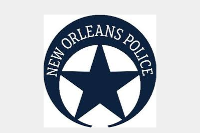

In [74]:
dash_wm = get_dash_wm(ops_dash)[0]
dash_wm

Let's visualize the web map so we can make a quick comparison to the results in our clone.


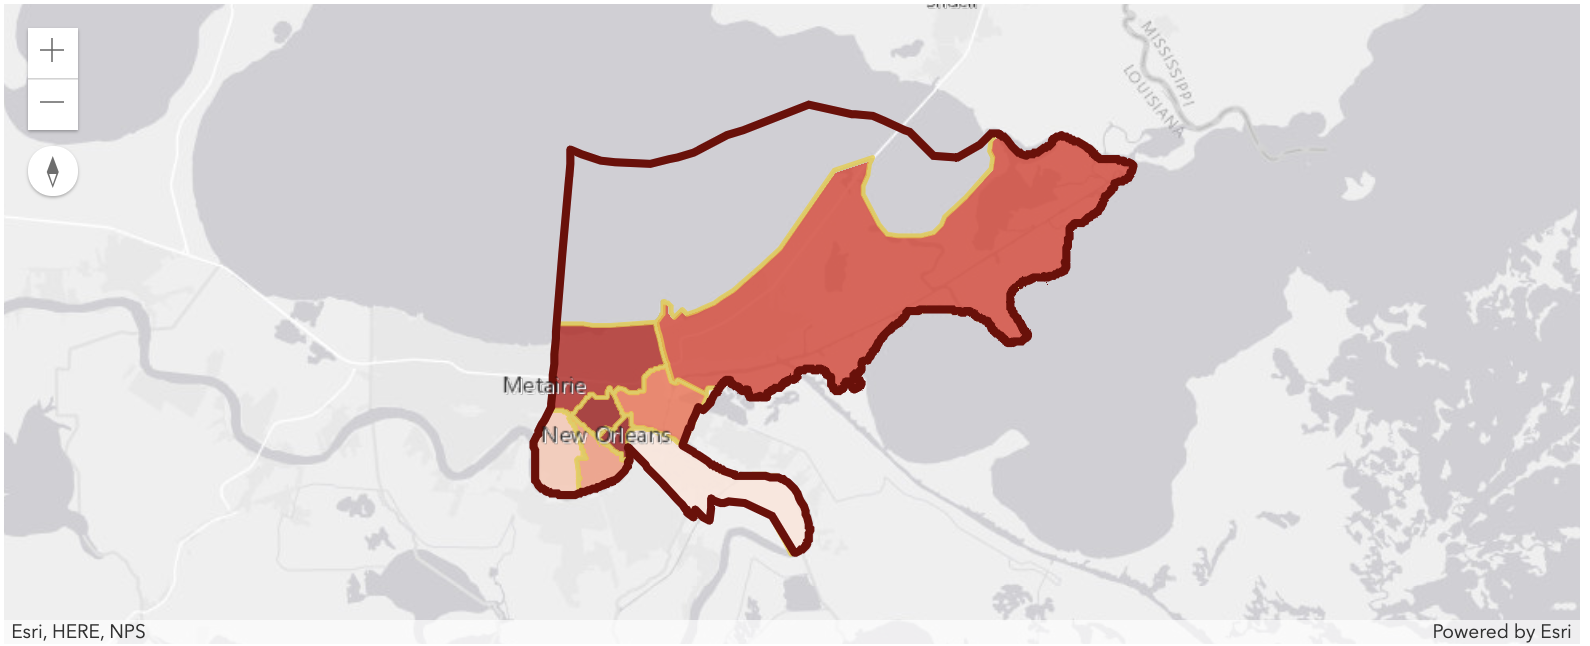

In [76]:
WebMap(dash_wm)

In [77]:
dash_wm.id

'5dfbd0b244a440d2ac097c4bf9b381a2'

In [78]:
print_webmap_inventory(dash_wm)

New Orleans Service Calls per Police District 2011-2019
----------------------------------------------------------------------------------------------------
  New Orleans City Boundary               HOSTED     ArcGISFeatureLayer  3b659cafd4dd4eb4acd09c161b307871
  NOLA_Police_District_Boundaries         HOSTED     ArcGISFeatureLayer  7bb9efeffe8847e7bec6515ac66376a8
  NOLA_ServiceCallTypes_by_PoliceDistrict HOSTED     ArcGISFeatureLayer  7c89adbcc6e648eda313fe9ededddf44




We used our helper functions to get a `dashboard` and examine the layers within the `web map` consumed in the `dashboard`.

Let's query the `wm_map` object we created to see if this `Web Map` id was cloned.

In [79]:
wm_item_mapping = {src_wm:trg_wm for src_wm,trg_wm in wm_map.items()
                  if dash_wm.id == src_wm}
wm_item_mapping

{'5dfbd0b244a440d2ac097c4bf9b381a2': 'b365110bedfe4396947d43a522fc9c2e'}

We cloned the `web map` used in this `dashboard` in our previous step of cloning `web maps`. We can use the `wm_item_mapping` we just created as the `item_mapping` parameter when cloning the `dashboard` to ensure the cloned `dashboard` consumed the cloned `web map` in the _target_ instead of staying wired up to the _source_ `web map`.

And since we're keeping the `search_existing_items` parameter with the default value of `True`, any `items` consumed in the `web map` will not get duplicated because of the `clone_items()` function using the `typeKeywords` search to use any _source_ item id value to map to any cloned `item` with that `id` in its `typeKeywords` list.

In [80]:
target.content.clone_items(items=[ops_dash],
                           folder="New Orleans",
                           item_mapping=wm_item_mapping)

[<Item title:"New Orleans Service Calls" type:Dashboard owner:clonerator>]

We now investigate our _target_ for the `dashboard` we just cloned.

In [81]:
target_admin_inventory = get_user_items(target.users.me, target)

<Item title:"New Orleans Service Calls" type:Dashboard owner:clonerator>
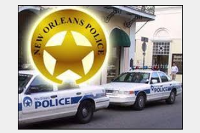

In [82]:
cloned_dash = target_admin_inventory['Dashboard'][0]
cloned_dash

In [83]:
active_gis = target

<Item title:"New Orleans Service Calls per Police District 2011-2019" type:Web Map owner:clonerator>
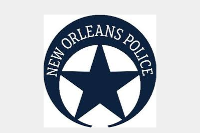

In [84]:
cloned_dash_webmap = get_dash_wm(cloned_dash)[0]
cloned_dash_webmap


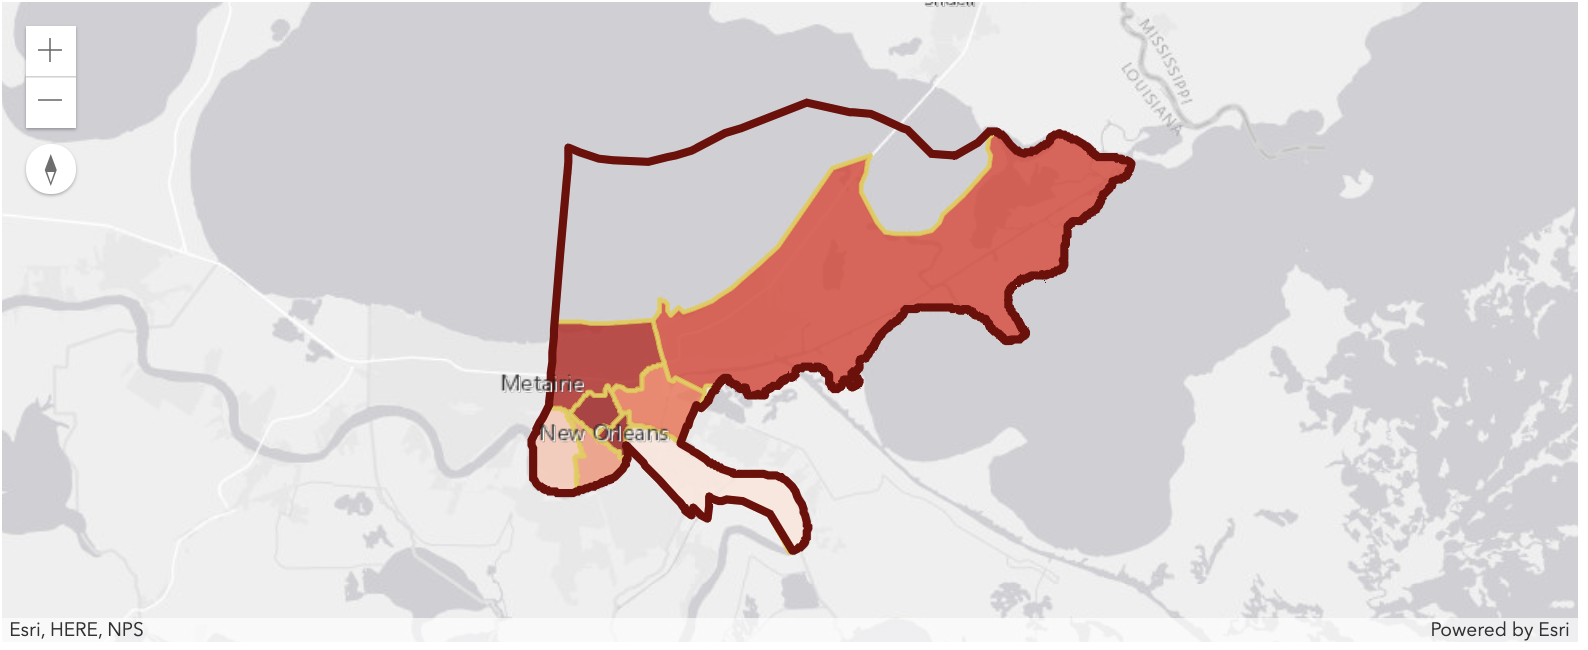

In [86]:
WebMap(cloned_dash_webmap)

In [87]:
cloned_dash_webmap.id

'b365110bedfe4396947d43a522fc9c2e'

In [88]:
print_webmap_inventory(cloned_dash_webmap)

New Orleans Service Calls per Police District 2011-2019
----------------------------------------------------------------------------------------------------
  New Orleans City Boundary               HOSTED     ArcGISFeatureLayer  422324e7cf65467493f721fda132b6f7
  NOLA_Police_District_Boundaries         HOSTED     ArcGISFeatureLayer  cc4d594a0a0f43bfb470275f8415c8e3
  NOLA_ServiceCallTypes_by_PoliceDistrict HOSTED     ArcGISFeatureLayer  efb953a5bc824b3a966fd08efd13066f




The `web map` cloned from the _source_ `dashboard` visually appears identical, and matches the `id` value from our `wm_map` object.

#### Story Maps

##### ArcGIS StoryMaps
As of version 1.8, the Python API does not yet support cloning [`ArcGIS StoryMaps`](https://www.esri.com/en-us/arcgis/products/arcgis-storymaps/overview). Stay tuned for announcements as to future capability.

##### Classic Story Maps
Classic story maps are stored in the portals as `Web Mapping Application` items, so let's use them as an example of cloning a web application item.

In [89]:
active_gis = source

<Item title:"Elephant Habitat and Relationship to Water" type:Web Mapping Application owner:arcgispyapibot>
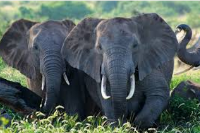

In [90]:
wma = source_admin_inventory['Web Mapping Application'][0]
wma

<Item title:"Elephant Corridors and Ranges" type:Web Map owner:arcgispyapibot>
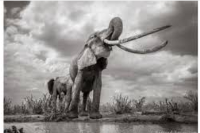

In [91]:
wma_webmap = source.content.get(wma.get_data()['values']['webmap'])
wma_webmap

For a quick visualization of the web map:


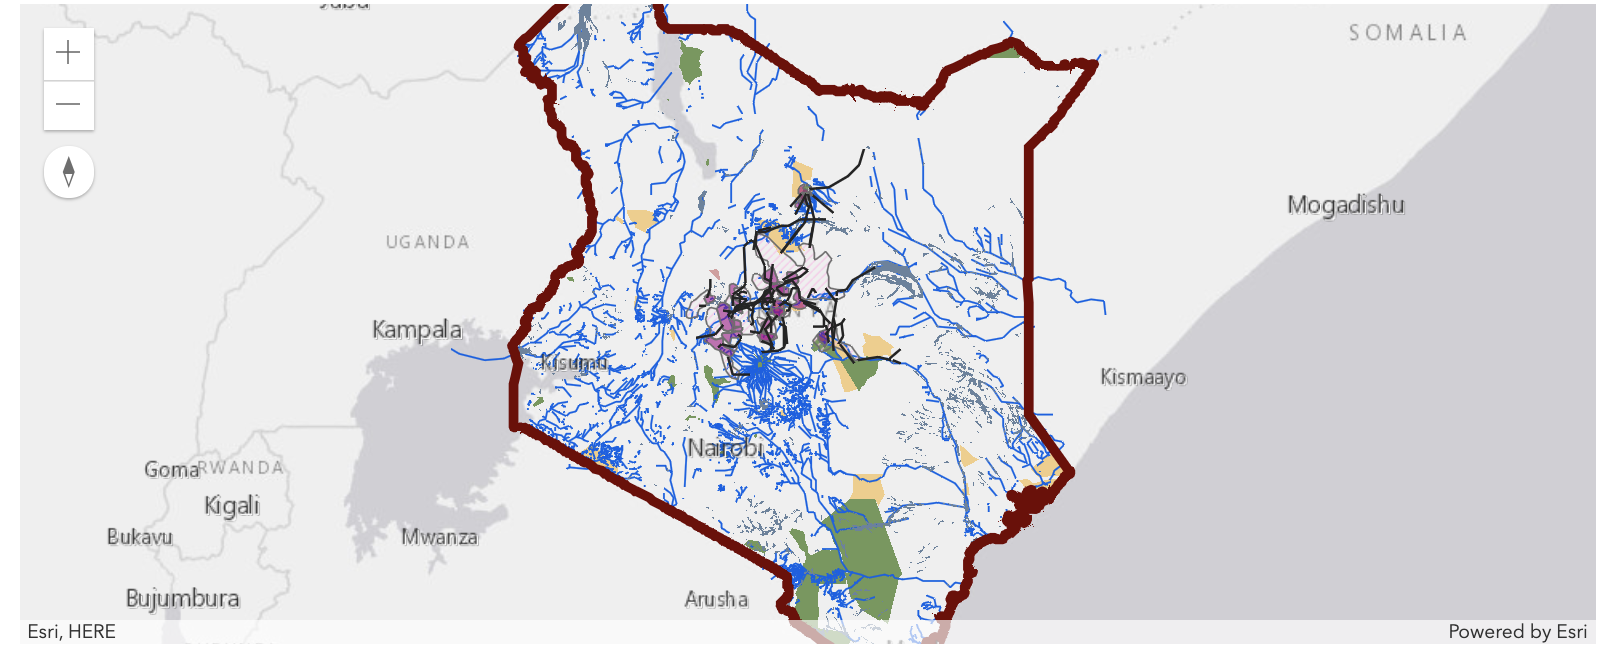

In [93]:
WebMap(wma_webmap))

In [94]:
wma_webmap.id

'485ec5def2b14e89b95d03fcfa7537d6'

In [95]:
print_webmap_inventory(wma_webmap)

Elephant Corridors and Ranges
----------------------------------------------------------------------------------------------------
  Elephant Natural Corridors              other      ArcGISFeatureLayer  Elephant_Natural_Corridors_1302
  Elephant Ranges                         other      ArcGISFeatureLayer  Elephant_Ranges_256
  KEN National Boundary                   HOSTED     ArcGISFeatureLayer  7b4a28846f0a40efb231e800840b72ec
  KEN Wetlands                            other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_7235
  KEN Waterways                           other      ArcGISFeatureLayer  Kenya_8543
  KEN Protected Areas                     other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_9906
  KEN County Boundaries                   HOSTED     ArcGISFeatureLayer  7b4a28846f0a40efb231e800840b72ec




Let's again query the _source_/_target_ dictionary we created when cloning the _source_ web maps to see if we've previously cloned the webmap consumed by the Story Map application.

In [96]:
wm_item_mapping = {src_wm:trg_wm for src_wm,trg_wm in wm_map.items()
                  if wma_webmap.id == src_wm}
wm_item_mapping

{'485ec5def2b14e89b95d03fcfa7537d6': 'cbca10bf6d824bfc8a9c164452932b80'}

The original [`Web Map`](https://developers.arcgis.com/python/api-reference/arcgis.mapping.html#webmap) contained 7 operational layers. 2 from a `hosted Feature Layer` in the `Web GIS`, and 5 `Feature Layers` items sourced from  ArcGIS Online Feature Layers. Let's use the `clone_items()` function,  accepting the default values for the `copy_data` and `search_existing_items` parameters (both `True`) and utilizing the existing item `wm_item_mapping` object to wire the application's web map. We'll then examine the results.

In [97]:
target.content.clone_items(items=[wma],
                           folder="Kenya",
                           item_mapping=wm_item_mapping)

[<Item title:"Elephant Habitat and Relationship to Water" type:Web Mapping Application owner:clonerator>]

We can see that cloning output of the `Web Mapping Application` lists the application. Let's further examine the cloned application for the items it consumes.

We'll query the target administrator inventory for the `Web Mapping Applications` now owned by the target admin, and then examine the `web map` it consumes.

In [98]:
active_gis = target

In [99]:
target_admin_inventory = get_user_items(target.users.me, target)

<Item title:"Elephant Habitat and Relationship to Water" type:Web Mapping Application owner:clonerator>
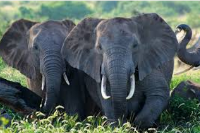

In [100]:
target_wma = target_admin_inventory['Web Mapping Application'][0]
target_wma

<Item title:"Elephant Corridors and Ranges" type:Web Map owner:clonerator>
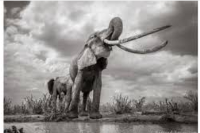

In [101]:
cloned_wma_webmap = target.content.get(target_wma.get_data()['values']['webmap'])
cloned_wma_webmap

To compare, the visualization of our cloned web map appears like our original source.


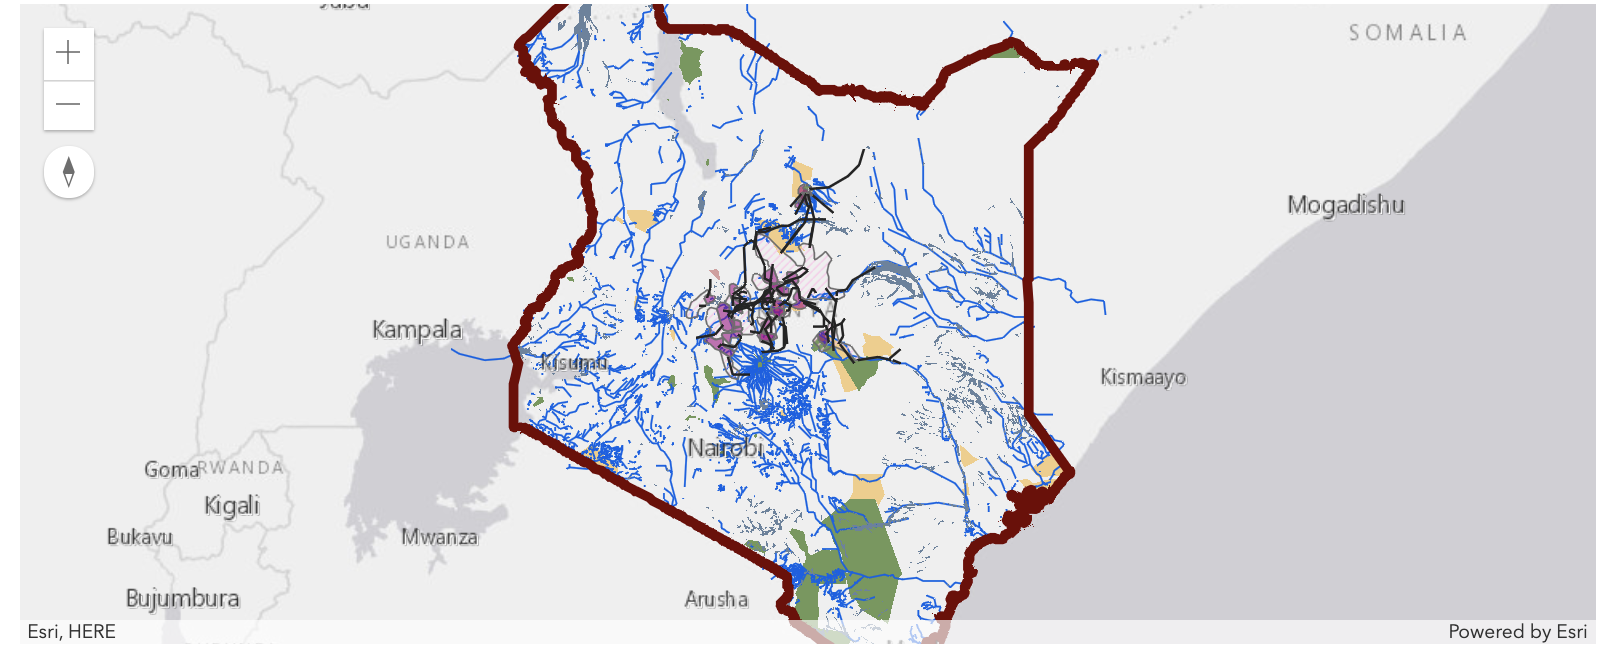

In [103]:
WebMap(cloned_wma_webmap))

In [104]:
cloned_wma_webmap.id

'cbca10bf6d824bfc8a9c164452932b80'

In [105]:
print_webmap_inventory(cloned_wma_webmap)

Elephant Corridors and Ranges
----------------------------------------------------------------------------------------------------
  Elephant Natural Corridors              other      ArcGISFeatureLayer  Elephant_Natural_Corridors_1302
  Elephant Ranges                         other      ArcGISFeatureLayer  Elephant_Ranges_256
  KEN National Boundary                   HOSTED     ArcGISFeatureLayer  be66aefdb6544d3386903cbec0309ad8
  KEN Wetlands                            other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_7235
  KEN Waterways                           other      ArcGISFeatureLayer  Kenya_8543
  KEN Protected Areas                     other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_9906
  KEN County Boundaries                   HOSTED     ArcGISFeatureLayer  be66aefdb6544d3386903cbec0309ad8




We can see that the `item_mapping` parameter ensured the cloned Story Map `Web Mapping Application` used the newly cloned `web map`. Examining the list of layers in the web map shows it has the same set of layers, including wiring up the layers to the correct newly cloned hosted feature services.

## Conclusion

This guide demonstrated one workflow for cloning items between a _source_ Web GIS and a _target_ Web GIS.  We connected to each GIS as an administrator and cloned a set of items using a bottom-up approach: first cloning the data services - `feature services` that comprise other items such as `web maps`. We examined how the `search_existing_items` parameter allows us to ensure against needless copying of data if we have already cloned items into our _target_.

After cloning the data building blocks, we cloned the `web maps`, again seeing how the `search_existing_items` parameter automatically mapped any `items` consumed in the `web map` from _source_ to a matching `item` in the _target_ if it exists. We then show how the `web maps` serve as building blocks for `web mapping applications` and `dashboards`, showing how the `item_mapping` parameter can serve to ensure the cloned _target_ item consumes the correct item or data services it consumed in the _source_. 

The `clone_items()` function provides the means to migrate data service items and more complex items that consume them between Web GIS systems. For items that consume other items, the function provides parameters to control the items they consume.